In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Set some display options for pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Load the data
# Make sure the .csv files are in the same directory as your script, or provide the full path.
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')



print("Shape of training data:", train_df.shape)
print("Shape of test data:", test_df.shape)

# Store the 'Id' columns to use for the submission file later
train_id = train_df['Id']
test_id = test_df['Id']

# Drop the 'Id' column as it is not a feature for modeling
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

print("\nFirst 5 rows of the training data:")
print(train_df.head())

Shape of training data: (1460, 81)
Shape of test data: (1459, 80)

First 5 rows of the training data:
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  Ove

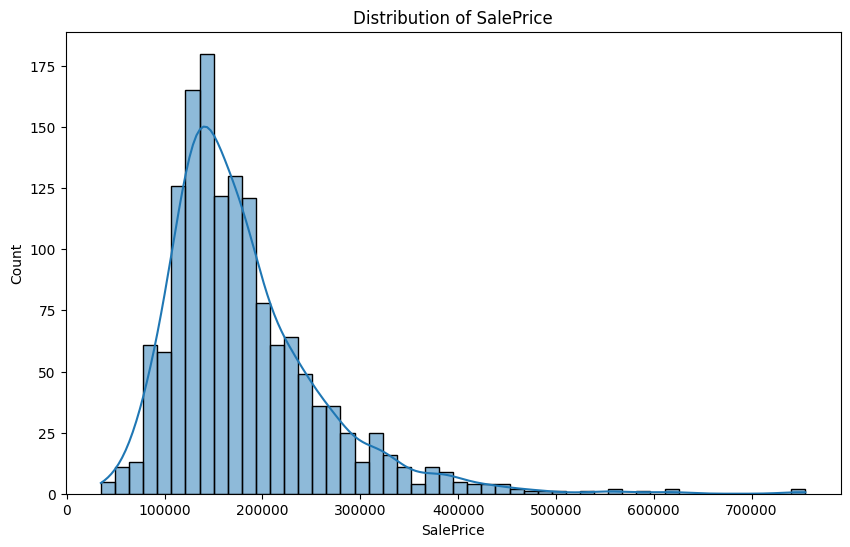

Skewness of SalePrice: 1.882876
Kurtosis of SalePrice: 6.536282


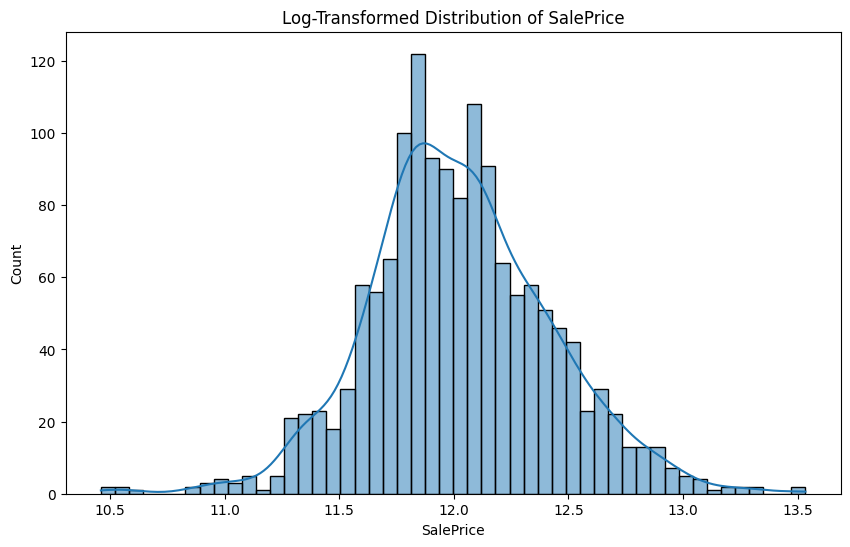


Shape of combined data: (2919, 79)

Features with missing values:
              Total Missing  Percentage
PoolQC                 2909   99.657417
MiscFeature            2814   96.402878
Alley                  2721   93.216855
Fence                  2348   80.438506
MasVnrType             1766   60.500171
FireplaceQu            1420   48.646797
LotFrontage             486   16.649538
GarageCond              159    5.447071
GarageFinish            159    5.447071
GarageYrBlt             159    5.447071
GarageQual              159    5.447071
GarageType              157    5.378554
BsmtExposure             82    2.809181
BsmtCond                 82    2.809181
BsmtQual                 81    2.774923
BsmtFinType2             80    2.740665
BsmtFinType1             79    2.706406
MasVnrArea               23    0.787941
MSZoning                  4    0.137033
BsmtHalfBath              2    0.068517
Functional                2    0.068517
BsmtFullBath              2    0.068517
Utilities    

In [ ]:
# 2: Exploratory Data Analysis (EDA) & Understanding the Data
# # --- Analyze the Target Variable: SalePrice ---
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.show()

print("Skewness of SalePrice: %f" % train_df['SalePrice'].skew())
print("Kurtosis of SalePrice: %f" % train_df['SalePrice'].kurt())

# The distribution is right-skewed. Log transformation is a common fix.
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of SalePrice')
plt.show()


# --- Analyze Missing Values ---
# Combine train and test data for consistent preprocessing
all_data = pd.concat((train_df.drop(['SalePrice'], axis=1), test_df))
print("\nShape of combined data:", all_data.shape)

# Find missing values and their percentage
missing_data = all_data.isnull().sum().sort_values(ascending=False)
missing_percent = (all_data.isnull().sum() / len(all_data) * 100).sort_values(ascending=False)
missing_info = pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percentage'])

print("\nFeatures with missing values:")
print(missing_info[missing_info['Total Missing'] > 0])

In [4]:
#3: Data Preprocessing (Handling Missing Values)
# --- Imputing Missing Values ---

# 1. Features where NaN means 'None' (no such feature)
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
    all_data[col] = all_data[col].fillna('None')

# 2. Features where NaN means 0
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']:
    all_data[col] = all_data[col].fillna(0)

# 3. Imputing LotFrontage based on the median of the neighborhood
# Group by neighborhood and fill missing values with the median of that group
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# 4. Mode imputation for features with few missing values
for col in ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# 5. Drop features with too many missing values or little variance
# Utilities has almost all the same value, so it's not useful
all_data = all_data.drop(['Utilities'], axis=1)

# Verify that there are no more missing values
print("\nMissing values remaining:", all_data.isnull().sum().sum())


Missing values remaining: 0


In [5]:
# Feature Engineering

# 1. Convert some numerical features that are really categories into strings
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# 2. Combine features to create more meaningful ones
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = all_data['FullBath'] + (0.5 * all_data['HalfBath']) + \
                       all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['3SsnPorch'] + \
                         all_data['EnclosedPorch'] + all_data['ScreenPorch'] + \
                         all_data['WoodDeckSF']

# 3. Create binary features
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFlr'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print("\nShape of data after feature engineering:", all_data.shape)

# --- Handling Skewed Numerical Features ---
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
high_skew = skewness[abs(skewness.Skew) > 0.75]

print(f"\nThere are {high_skew.shape[0]} skewed numerical features to Box Cox transform")
for feat in high_skew.index:
    all_data[feat] = np.log1p(all_data[feat])

# --- One-Hot Encoding for Categorical Features ---
# This converts categorical variables into a form that can be provided to ML algorithms
final_data = pd.get_dummies(all_data, drop_first=True)
print("\nShape of final data after one-hot encoding:", final_data.shape)


Shape of data after feature engineering: (2919, 86)

There are 27 skewed numerical features to Box Cox transform

Shape of final data after one-hot encoding: (2919, 300)


In [ ]:
#Modeling & Evaluation
#  --- Separate data back into train and test sets ---
n_train = train_df.shape[0]
X = final_data[:n_train]
y = train_df['SalePrice']
X_test = final_data[n_train:]

print("\nTrain set shape:", X.shape)
print("Test set shape:", X_test.shape)

# --- Build a Model ---
# We use Ridge regression, which is a good baseline model for this type of problem.
# It's a linear model with L2 regularization, which helps prevent overfitting.
ridge = Ridge(alpha=10) # alpha is the regularization strength

# Train the model
ridge.fit(X, y)

# Make predictions on the training data to calculate RMSE
y_pred_log = ridge.predict(X)

# We need to transform the predictions back to the original scale before calculating error
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"\nRoot Mean Squared Error (RMSE) on training data: ${rmse:,.2f}")


# --- Generate Submission File ---
# Predict on the actual test set
test_pred_log = ridge.predict(X_test)
test_pred = np.expm1(test_pred_log)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully!")


Train set shape: (1460, 300)
Test set shape: (1459, 300)

Root Mean Squared Error (RMSE) on training data: $23,527.34

Submission file 'submission.csv' created successfully!
